In [1]:
!pip install audiolazy soundfile

  Using cached audiolazy-0.6-py2.py3-none-any.whl (121 kB)
  Using cached SoundFile-0.10.3.post1-py2.py3-none-any.whl (21 kB)


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
from skimage.util.shape import view_as_windows
from scipy import signal
from audiolazy import lpc
import IPython.display as ipd
from audiolazy import levinson_durbin
import speech_test
%matplotlib inline
plt.rcParams.update({'font.size': 18})

# Toolbox

In [3]:
def CalcLPC_AC(input_lpc_frame, lpc_order):
    
    filt = lpc.autocor(input_lpc_frame, lpc_order)
    
    delta_input = np.zeros((lpc_order+1))
    
    delta_input[0] = 1
    
    #print(delta_input)
    #print(filt)
    
    lpc_coeffs = filt(delta_input)
    
    lpc_coeffs = [float(x) for x in lpc_coeffs]
    
    # Calculate the lpc_coefficients, using the lpc from audiolazy
    # input:
    # input_lpc_frame: time domain input frame
    # lpc_order: lpc order
    # output:
    # lpc_coeffs: The lpc_coefficients
    return lpc_coeffs



test_frame = [-1, 0, 1, 0, -1, 0, 1, 0, -1, 0, 1, 0, -1, 0, 1, 0]
lpc_order = 8
estimated_out = [1, 0.0, 0.9230769230769231, 0.0, 2.391249591500338e-16, 0.0, 5.828670879282072e-16, 0.0, 0.07692307692307729]

CalcLPC_AC(test_frame, lpc_order)




[1.0,
 3.9670957491244607e-16,
 0.9230769230769258,
 2.8709673527416157e-16,
 4.218847493575595e-15,
 -1.687018580387445e-16,
 2.4424906541753444e-15,
 1.3422422895370545e-16,
 0.07692307692307665]

In [4]:
# Test cell for function CalcLPC_AC

assert speech_test.test_AC(CalcLPC_AC)

In [5]:
def autocorr(x):
    
    full_correl = np.correlate(x,x, 'full')
    
    corr_len = np.shape(full_correl)[0]
    
    first_els = int(np.floor(corr_len/2))
    
    result = np.delete(full_correl, range(first_els))
    # Calculate the full autocorrlelation using the numpy function correlate
    # and return only second half of it
    # input:
    # x: time domain input frame
    # output:
    # result: autocorrelation vector
    
    return result

In [6]:
testVec = np.array([1,0,0])

autocorr(testVec)


array([1, 0, 0])

In [7]:
def CalcLPC_LD(input_lpc_frame, lpc_order):
    
    acdata = autocorr(input_lpc_frame)
    #print(acdata)
    ldfilt = levinson_durbin(acdata, lpc_order)
    
    
    delta_input = np.zeros((lpc_order+1))
    
    delta_input[0] = 1
    
    #print(delta_input)
    #print(ldfilt)
    
    ld_coeffs = ldfilt(delta_input)
    
    ld_coeffs = [float(x) for x in ld_coeffs]
    
    # Steps: 1. Estimate the autocorrelation
    #       2. Use levinson-durbin algorithm to calc the coefficients
    # Hint: levinson_durbin-algorithm gives as an output polynomials.
    #       Extract the coefficients!
    # input:
    # input_lpc_frame: time domain input frame
    # lpc_order: lpc order
    # output:
    # lpc_coeffs: The lpc_coefficients
    return ld_coeffs


test_frame = [-1, 0, 1, 0, -1, 0, 1, 0, -1, 0, 1, 0, -1, 0, 1, 0]
lpc_order = 8
estimated_out = [1, 0.0, 0.9230769230769231, 0.0, 2.391249591500338e-16, 0.0, 5.828670879282072e-16, 0.0, 0.07692307692307729]

CalcLPC_LD(test_frame, lpc_order)

[1.0,
 0.0,
 0.9230769230769231,
 0.0,
 2.391249591500338e-16,
 0.0,
 5.828670879282072e-16,
 0.0,
 0.07692307692307729]

In [8]:
# Test cell for function CalcLPC_LD
assert speech_test.test_LD(CalcLPC_LD)

In [9]:
def manipulate_lpc(lpc_coeffs):
    # input:
    # lpc_coeffs: lpc coefficients
    # output:
    # formants_in_z: guessed formants in z domain
    # Steps:
    # Find the roots using the numpy 'roots' function
    roots_in_z = np.roots(lpc_coeffs)

    # order the roots in descending order of magnitude
    roots_in_z = np.array(sorted(roots_in_z, key = lambda root: np.abs(root), reverse = True))

    # Omit DC and negative angles from the ordered roots in the previous step
    roots_noDc = []
    for i in range(len(roots_in_z)):
        if np.imag(roots_in_z)[i] != 0 and np.angle(roots_in_z)[i] > 0:
            roots_noDc = np.append(roots_noDc, roots_in_z[i])
    roots_noDc = np.append(roots_noDc,
                           np.array([float('nan')]*(3-len(roots_noDc))))
    formants_in_z = roots_noDc[:3]

    # order the roots in ascending order of frequency
    formants_in_z = np.array(sorted(formants_in_z, key = lambda formant: np.angle(formant)))
    return formants_in_z

In [10]:
# Test cell for function manipulate_lpc
assert speech_test.test_formants(manipulate_lpc)

In [11]:
# Write a function to determine the frequency of a root in the z plane.
def complex2hertz(complex_numbers, fs):
    
     
    hertz =  ( np.angle(complex_numbers) / (2*np.pi) ) * fs
    
    #print(hertz)
    
    return hertz

In [12]:
# Test cell for function complex2hertz
assert speech_test.test_complex2hertz(complex2hertz)

In [13]:
def CalcResPredGain(lpc_coeffs, input_frame):
    # Calculate residual by using the filter function (scipy.signal.lfilter)
    # input:
    # input_lpc_frame: time domain input frame
    # lpc_coeffs: The lpc_coefficients
    # output:
    # res: residual: the filtered input_frame
    # predGain: Prediction gain according to the formula in the script
    
    
    # Filter the input frame
    
    
    denominator_coeffs = np.zeros(np.shape(lpc_coeffs)[0]) # poles -> IIR Anteil
    denominator_coeffs[0] = 1 # only FIR filter....
    
    numerator_coeffs = lpc_coeffs # zeroes -> FIR Anteil
    
    residual = signal.lfilter(numerator_coeffs,  denominator_coeffs , input_frame)
    
    #print(residual)
    
    energy_input = np.dot(input_frame, input_frame) # signal energy...
    
    energy_residual = np.dot(residual, residual) # residual energy...
    
    #print(energy_input)
    #print(energy_residual)


   

    # Calculate the powers of the input and the residual
    # Calculate the prediction gain
    
    predGain = 10 * np.log10(energy_input / energy_residual) # prediction gain in DB...
    res = residual
    
    return res, predGain

In [14]:
# Test cell for function CalcResPredGain
assert speech_test.test_CalcResPredGain(CalcResPredGain)

In [15]:
# Calculate a vector of frequencies out of the win_len and fs
def freq_vec(winlen, fs):
    
    f = np.zeros(winlen)
    
    for i in range(winlen):
        f[i] = fs*(i/winlen)
    
    # input:
    # winlen: length of the window
    # fs: sampling frequency
    # output:
    # f: the resulting frequency of each bin when transformed applying DFT
    return f

freq_vec(4, 100)

array([ 0., 25., 50., 75.])

# Visualization

In [16]:
def plot_in_zplane(roots, ax=None):
    circle = plt.Circle((0, 0), 1, edgecolor='black',
                        fill=False, linewidth=0.5)
    zero_line = plt.Line2D(xdata=[-1, 1], ydata=[0, 0],
                           color='black', linewidth=0.5)

    if ax is None:
        f, ax = plt.subplots(1, 1)
    # centre
    ax.plot([0], [0], marker='o', markersize=3, color="black")
    # roots
    ax.scatter(np.real(roots), np.imag(roots))
    ax.add_artist(circle)
    ax.add_artist(zero_line)
    ax.axis([-1, 1, -1, 1])
    ax.set_title('Filter in Z-plane')
    ax.set_aspect(1)
    return ax

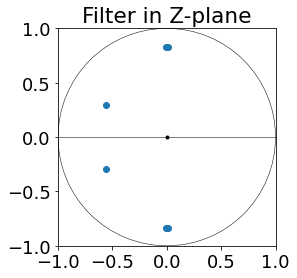

In [17]:
# Test cell for function plot_in_zplane
test_roots = [0.011473177123205891+0.8323403782470172j,
              -0.011473177123206394+0.8323403782470116j,
              -0.561863850275283+0.29081020669423574j,
              0.011473177123205891-0.8323403782470172j,
              -0.011473177123206394-0.8323403782470116j,
              -0.561863850275283-0.29081020669423574j]
plot_in_zplane(test_roots)

In [18]:
def visualizeSpec(input_frame, res, res_ho, fs, ax=None):
    # Calculate the frequency range
    f = freq_vec(len(input_frame), fs)
    #print(f)
    
    input_fft = 20*np.log10(np.abs(np.fft.fft(input_frame)))
    res_fft = 20*np.log10(np.abs(np.fft.fft(res)))
    res_ho_fft = 20*np.log10(np.abs(np.fft.fft(res_ho)))
    

    # start the figure
    if ax is None:
        fig, ax = plt.subplots(1, figsize=(14,7))
        #vermutung hier:
    ax.plot(f, input_fft, label = 'input frame')
    ax.plot(f, res_fft, label = 'residual')
    ax.plot(f, res_ho_fft, label='residual higher order') # residuum higher order

        
    # use ax.plot to visualize the input frame and the residual for both
    # filter orders. Use labels and different colors.
    ax.set_title('Frequency Domain')
    ax.set_ylabel('Amplitude [dB]')
    ax.set_xlabel('Frequency [Hz]')
    ax.legend()
    return ax

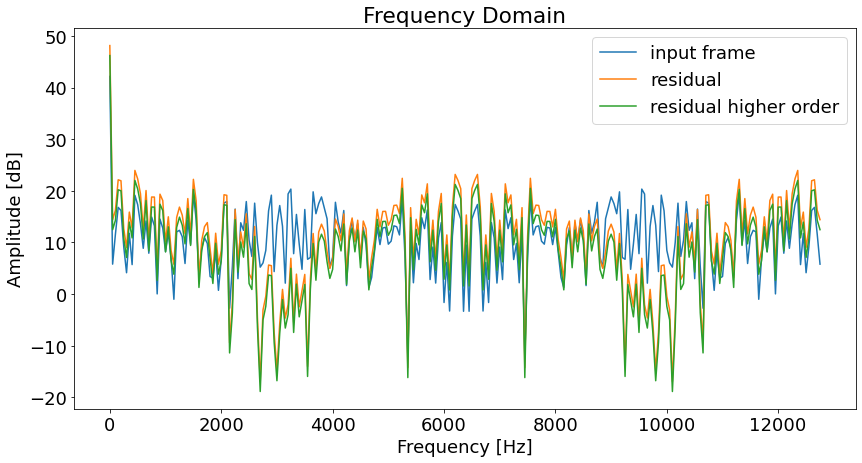

In [19]:
# Test cell for function visualizeSpec

test_sig = np.random.random(256)
test_lpc = [1, 0.0, 0.9230769230769231, 0.0, 2.391249591500338e-16, 0.0,
            5.828670879282072e-16, 0.0, 0.07692307692307729]
res, predG = CalcResPredGain(test_lpc, test_sig)
visualizeSpec(test_sig, res, res*0.8, fs=12800, ax=None)

In [20]:
# Test cell for function visualizeSpec
def visualizeTimeDom(input_frame, res, res_ho, ax=None):

    # start the figure
    if ax is None:
        fig, ax = plt.subplots(1, figsize=(14,7))
        # Vermutung hier:
    ax.plot(input_frame, label = 'input frame')
    ax.plot(res, label = 'residual')
    ax.plot(res_ho, label='residual higher order') # residuum higher order
    # use ax.plot to visualize the input frame and the residual for both
    # filter orders. Again use colors and labels.
    ax.set_title('Time Domain')
    ax.set_ylabel('Amplitude')
    ax.set_xlabel('Sample')
    ax.legend()
    return ax

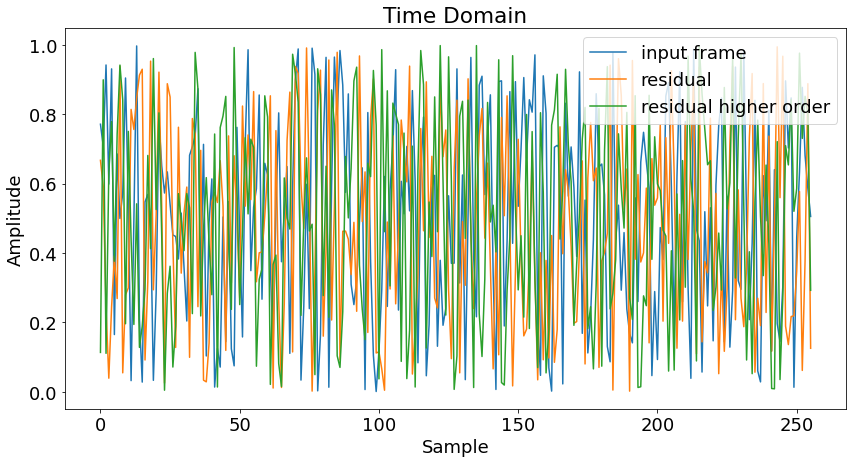

In [21]:
# Test cell for function visualizeSpec
visualizeTimeDom(test_sig, np.random.random(256), np.random.random(256))

In [22]:
# Test cell for function visualizeSpec
def visualizeFilterFreqRes(lpc_coeffs, fs, winlen, ax=None):
    # calculate the frequency response (magnitude) of the lpc_coeffs with the
    # help of the function signal.freqz().
    freq = freq_vec(winlen, fs)
    
    delta_input = np.zeros(np.shape(lpc_coeffs)[0])
    delta_input[0] = 1
    
    #jetzt halt immer Symmetrisch, man könnte eig auch nur die erste Hälfte darstellen mit whole=False, wegen Nyquist 1/2 freq und so weil reelles signal...
    freq_resp = signal.freqz(lpc_coeffs, worN=winlen, whole=True)
    
    # start the figure
    if ax is None:
        fig, ax = plt.subplots(1)
    ax.set_title('Filter Frequency Response')
    #print(freq_resp)
    #print(" ")
    #print(freq)
    ax.plot( freq, 20*np.log10(np.abs(freq_resp[1])) )
    

    # use a.plot to visualize the lpc filters
    ax.set_ylabel('Amplitude [dB]')
    ax.set_xlabel('Frequency [Hz]')
    return ax

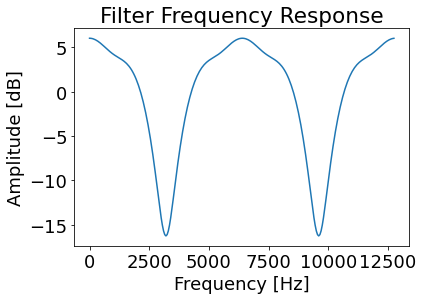

In [23]:
# Test cell for function visualizeFilterFreqRes
visualizeFilterFreqRes(test_lpc, fs=12800, winlen=256, ax=None)

In [24]:
# Test cell for function visualizeSpec
def plotOverview(input_frame, res, res_ho, lpc_coeffs_lo, lpc_coeffs_ho, fs):

    fig, ax = plt.subplots(3, 2, figsize=(20, 20))
    fig.subplots_adjust(hspace=0.35, wspace=0.3)
    visualizeSpec(input_frame, res, res_ho, fs, ax=ax[0, 0])
    visualizeTimeDom(input_frame, res, res_ho, ax=ax[0, 1])
    plot_in_zplane(np.roots(lpc_coeffs_lo), ax=ax[1, 0])
    plot_in_zplane(np.roots(lpc_coeffs_ho), ax=ax[1, 1])
    visualizeFilterFreqRes(lpc_coeffs_lo, fs, len(input_frame), ax=ax[2, 0])
    visualizeFilterFreqRes(lpc_coeffs_ho, fs, len(input_frame), ax=ax[2, 1])

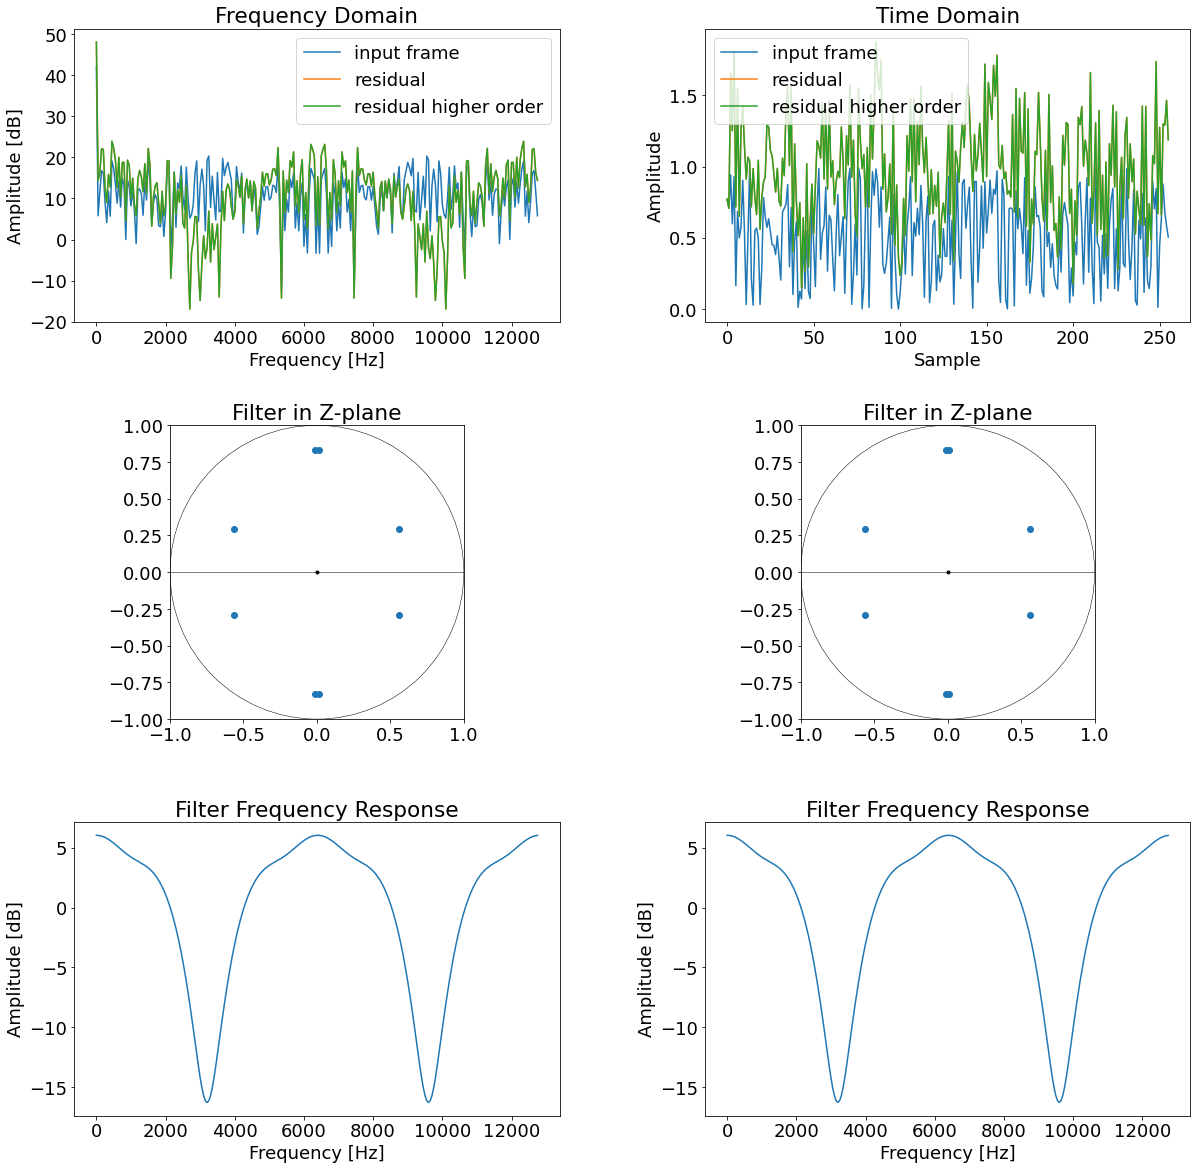

In [25]:
# Test cell for function plotOverview
plotOverview(test_sig, res, res, test_lpc, test_lpc, fs=12800)

In [26]:
# close all figures if script is run as .py file
plt.close('all')

# Main Process

In [27]:
# Parameters
fs = 12800

# In this case, a perfect estimated tube model is not the goal, but rather
# identifying the first 3 formants. Therefore, the lpc order is chosen to
# be 8.
lpc_order = 8

# Calculate the higher order of LPC, according to the tube model
lpc_higher_order = int(np.ceil((2*fs*0.16)/334))

# Calculate window-length for the lpc estimation
F0 = 100  # 2 periods of F0, lets assume F0 = 100Hz
lpc_winlen = int((fs/F0)*2)

# Calculate window-length for the processing
# stationarity = 20ms
winlen = int(fs*(0.02))



Concatenated Phonemes


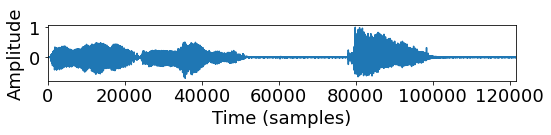

44100


In [28]:
# Choose and load the file female_english_short.wav from the Signals folder

from IPython.display import Audio



print('Concatenated Phonemes')

speech_dry, Fs_speech = sf.read('audio/concatenated_phonemes.wav')
display( Audio(speech_dry, rate=Fs_speech) )









#print('Voice Female')

#speech_dry, Fs_speech = sf.read('audio/female_english_short.wav')
#display( Audio(speech_dry, rate=Fs_speech) )

plt.figure(figsize=(8, 2))
plt.plot(speech_dry)
plt.xlim([0, speech_dry.shape[0]])
plt.xlabel('Time (samples)')
plt.ylabel('Amplitude')
plt.tight_layout()
plt.show()


print(Fs_speech)

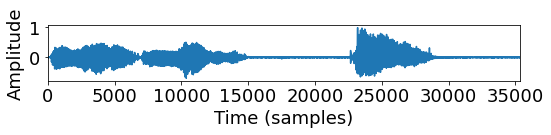

In [29]:
# Resample it to the chosen sampling frequency fs by first calculating the
# length of the signal at the desired sampling frequency and then hand it to
# signal.resample()

signal_length = np.shape(speech_dry)[0]

new_length = int( signal_length * (fs / Fs_speech) )

speech = signal.resample(speech_dry, new_length)

display( Audio(speech, rate=fs) )

plt.figure(figsize=(8, 2))
plt.plot(speech)
plt.xlim([0, speech.shape[0]])
plt.xlabel('Time (samples)')
plt.ylabel('Amplitude')
plt.tight_layout()
plt.show()







# for further variable names:
input_orig = speech_dry
fs_orig = Fs_speech
input_resampl = speech
fs_resampl = fs


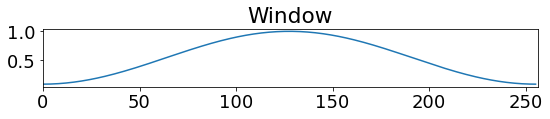

(274, 256)


In [30]:
#step = winlen//2



window = np.hamming(lpc_winlen)
frames = view_as_windows(np.ascontiguousarray(input_resampl),
                         winlen,
                         step=winlen//2)
wincnt = len(frames)


plt.figure(figsize=(8, 2))
plt.title('Window')
plt.plot(window)
plt.xlim([0, window.shape[0]])
plt.tight_layout()
plt.show()

print(np.shape(frames))

In [31]:
# Initialize the matrix to store the lpc_coeffs and formants
mtx_coeff = np.zeros((wincnt, lpc_order+1))  # type- ndarray
mtx_coeff_ho = np.zeros((wincnt, lpc_higher_order+1))
mtx_formants = np.zeros((wincnt, 3), dtype=complex)  # 3-number of formants
mtx_formants_hz = np.zeros((wincnt, 3))
mtx_res = np.zeros((wincnt, lpc_winlen))
mtx_res_ho = np.zeros((wincnt, lpc_winlen))
input_mtx = np.zeros((wincnt, winlen))
input_lpc_mtx = np.zeros((wincnt, winlen))
predGain = np.zeros((wincnt))
predGain_ho = np.zeros((wincnt))

In [32]:
# Framewise processing of the input file.

for i, one_frame in enumerate(frames):
    # skip windows with no energy
    if np.mean(np.square(one_frame)) == 0:
        continue
    
    
    # Window the LPC Frame
    input_lpc_mtx[i] = one_frame*window

    # mtx_coeff[i]:
    # Use CalcLPC_AC and CalcLPC_LD to calculate the LPC-s
    # and compare the results with the np.allclose function

    mtx_coeff[i] = CalcLPC_AC(input_lpc_mtx[i], lpc_order)
    lpc_coeffs_ld = CalcLPC_LD(input_lpc_mtx[i], lpc_order)
    np.allclose(mtx_coeff[i], lpc_coeffs_ld)

    # mtx_formants[i]:
    # Estimate the formants using 'manipulate_lpc'
    mtx_formants[i] = manipulate_lpc(mtx_coeff[i])

    # mtx_formants_hz[i]:
    # Calculate the formants frequencies in Hz
    mtx_formants_hz[i] = complex2hertz(mtx_formants[i], fs)

    # mtx_coeff_ho[i]:
    # Shape the tubemodel, choose a higher prediction Order
    # Calculate LPC using a higher prediction order
    mtx_coeff_ho[i] = CalcLPC_AC(input_lpc_mtx[i], lpc_higher_order)

    # mtx_res[i], predGain[i]:
    # mtx_res_ho[i], predGain_ho[i]:
    # Calculate the residuals and the prediction gain for both filter orders
    # using the function CalcResPredGain
    mtx_res[i], predGain[i] = CalcResPredGain(mtx_coeff[i], one_frame)
    mtx_res_ho[i], predGain_ho[i] = CalcResPredGain(mtx_coeff_ho[i], one_frame)

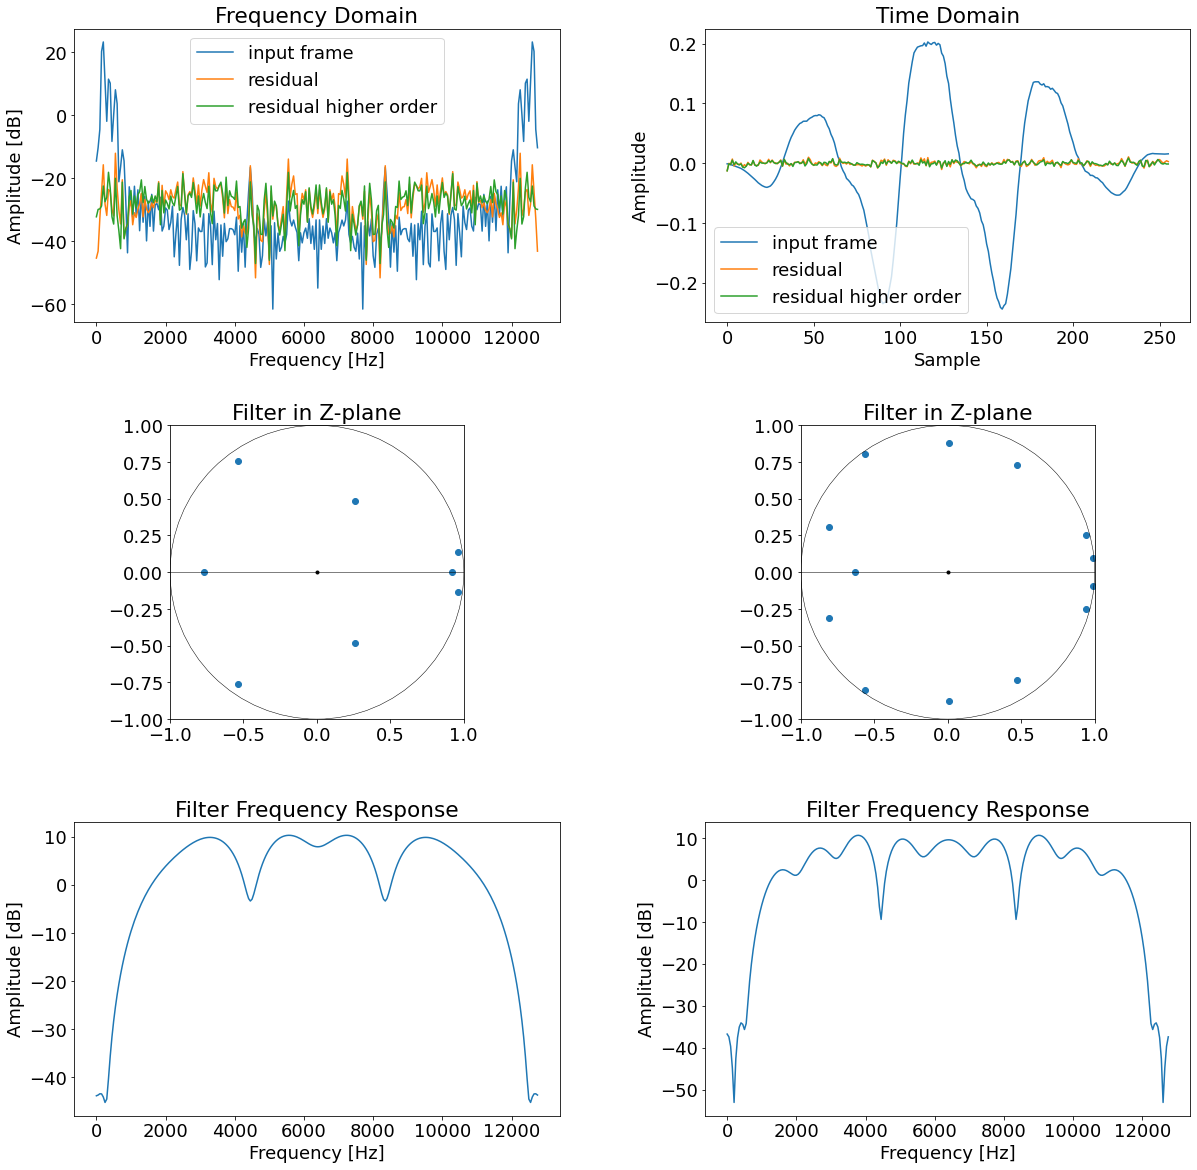

In [33]:
# Compare the plots of different frames.
nice_frame_idx = 64

plotOverview(input_lpc_mtx[nice_frame_idx],
             mtx_res[nice_frame_idx],
             mtx_res_ho[nice_frame_idx],
             mtx_coeff[nice_frame_idx],
             mtx_coeff_ho[nice_frame_idx],
             fs=12800)

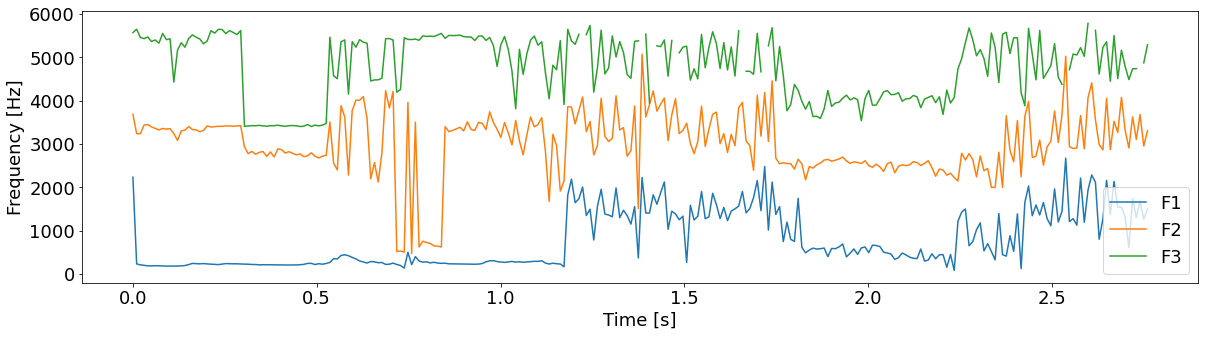

In [34]:
# Change the audio input file to be "concatenated_phonemes.wav"
# at the beginning of the Main Process and run it to analyze the audio file

# Plot the estimated formant frequencies mtx_formants_hz.
# time:
# Calculate the x-axis scale in seconds.
time_step = (len(input_resampl)/fs)/(len(mtx_formants_hz)-1)
time = np.arange(0, len(mtx_formants_hz)) * time_step

# Plot each formant frequency as seperate line in one graph over time.
fig = plt.figure(figsize=(20, 5))
ax = fig.add_subplot(1, 1, 1)
ax.plot(time, mtx_formants_hz[:, 0], label='F1')
ax.plot(time, mtx_formants_hz[:, 1], label='F2')
ax.plot(time, mtx_formants_hz[:, 2], label='F3')
ax.set_ylabel('Frequency [Hz]')
ax.set_xlabel('Time [s]')
ax.legend()